In [11]:
!pip install Pillow matplotlib


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from torch.utils.data import random_split
import torch.nn as nn

In [13]:
dataset_path = './dataset/dataset.csv'
image_path = './data/abo-images-small/images/small/'

In [14]:
from matplotlib import pyplot as plt
from PIL import Image

def show_image(image_url):
    # Load the image using PIL
    img = Image.open(image_url)

    plt.imshow(img)
    plt.axis('off') 
    plt.show()

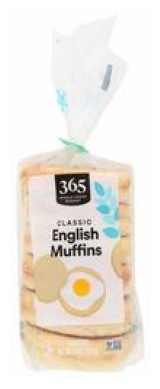

In [15]:
show_image(f'{image_path}6a/6a8d8df6.jpg')

In [16]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, file_path, img_dir, transform=None):
        # read csv file
        self.data = pd.read_csv(file_path)
        self.img_dir = img_dir
        self.transform = transform
        
        # Convert category labels to unique indices
        self.category_labels = {}
        for i in range(1, 7):
            column_name = f'category_{i}'
            self.data[column_name] = self.data[column_name].fillna('UNK')
            self.data[f'{column_name}_idx'] = self.data[column_name].astype('category').cat.codes
            self.category_labels[column_name] = dict(enumerate(self.data[column_name].astype('category').cat.categories))
        
        self.num_categories = 6

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 2])
        # some of the dataset images are in bw (1, 224, 224)
        # to address this inconsistency and convert all of them into rgb (3, 224, 224)
        image = Image.open(img_name).convert('RGB')
        
        labels = []
        for i in range(1, 7):
            labels.append(self.data.iloc[idx, -(self.num_categories - (i - 1))])
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels)

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
dataset = MultiLabelImageDataset(dataset_path, image_path, transform=transform)

In [19]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  # 70% training
dev_size = int(0.15 * dataset_size)   # 15% validation 
test_size = dataset_size - train_size - dev_size  # 15% test

# randomly split the dataset
train_dataset, dev_dataset, test_dataset = random_split(dataset, [train_size, dev_size, test_size])

In [20]:
# DataLoaders for each dataset

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
image, labels = train_dataset[0]
# show_image(image)
print(labels)

tensor([ 48, 228, 506, 699, 130,  10], dtype=torch.int16)


In [22]:
class MultiTaskCNN(nn.Module):
    def __init__(self, num_classes_list):
        super(MultiTaskCNN, self).__init__()

        # feature extraction block
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # fully connected layers
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU()
        )

        # classifier layers for each category level
        self.fc1 = nn.Linear(512, num_classes_list[0])
        self.fc2 = nn.Linear(512, num_classes_list[1])
        self.fc3 = nn.Linear(512, num_classes_list[2])
        self.fc4 = nn.Linear(512, num_classes_list[3])
        self.fc5 = nn.Linear(512, num_classes_list[4])
        self.fc6 = nn.Linear(512, num_classes_list[5])

    def forward(self, x):
        # Shared features
        x = self.conv_block(x)
        x = self.fc_block(x)

        # separate classifier layers for 
        output1 = self.fc1(x)
        output2 = self.fc2(x)
        output3 = self.fc3(x)
        output4 = self.fc4(x)
        output5 = self.fc5(x)
        output6 = self.fc6(x)

        return output1, output2, output3, output4, output5, output6

In [23]:
# function to train the model and return losses over epochs
def train(model, data_loader, optimizer, num_epochs = 10, criterion = []):
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_dataloader:
            optimizer.zero_grad()
            cat_1, cat_2, cat_3, cat_4, cat_5, cat_6 = model(images)
            
            # loss for each task
            loss_1 = criterion[0](cat_1, labels[:, 0].long())
            loss_2 = criterion[1](cat_2, labels[:, 1].long())
            loss_3 = criterion[2](cat_3, labels[:, 2].long())
            loss_4 = criterion[3](cat_4, labels[:, 3].long())
            loss_5 = criterion[4](cat_5, labels[:, 4].long())
            loss_6 = criterion[5](cat_6, labels[:, 5].long())
            
            # total loss
            loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataloader.dataset)
        
        # TODO: Validate after each epoch over dev data
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

In [24]:
import torch.optim as optim
import torch.nn.functional as F

# loss for each auxiliary task
criterion = [nn.CrossEntropyLoss() for _ in range(6)]

# num of possible categories 
num_classes_list = [len(train_dataset.dataset.data[f'category_{i+1}'].astype('category').cat.categories) for i in range(6)]

# Instantiate the model
model = MultiTaskCNN(num_classes_list)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_classes_list

[146, 465, 1039, 749, 138, 11]

In [16]:
train(model= model, data_loader= train_dataloader, optimizer= optimizer, criterion= criterion, )                                                                                                                                                    12aq

KeyboardInterrupt: 

In [2]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [25]:
# the evaluate function takes in model, data to evaluate, criterion to evaluate with and device 
# it computes loss per task, total combined loss, accuracy per task, f1 per task and returns them as a dictionary

def evaluate(model, data_loader, criterion = None, device = 'cpu'):
    # loading eval mode to not use dropouts and batchnorms
    model.eval()  
    
    total_loss = 0
    individual_losses = [0] * 6  
    accuracy = [0] * 6
    f1_scores = [0] * 6 
    all_labels = [[] for _ in range(6)]  # ground truth
    all_predictions = [[] for _ in range(6)] # predictions
    
    with torch.no_grad():  
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            batch_losses = []
            for i in range(6):
                if criterion:
                    loss = criterion[i](outputs[i], labels[:, i].long())
                    individual_losses[i] += loss.item() * images.size(0)
                    batch_losses.append(loss.item())
                
                _, predicted = torch.max(outputs[i], 1)
                # fix for error in accuracy_score, f1_score functions
                # convert to numpy list 
                all_labels[i].extend(labels[:, i].cpu().numpy())
                all_predictions[i].extend(predicted.cpu().numpy())
            
            combined_loss = sum(batch_losses)
            total_loss += combined_loss

    avg_individual_losses = [loss / len(data_loader.dataset) for loss in individual_losses]
    avg_combined_loss = total_loss / len(data_loader.dataset)
    for i in range(6):
        accuracy[i] = accuracy_score(all_labels[i], all_predictions[i],)
        f1_scores[i] = f1_score(all_labels[i], all_predictions[i], average='weighted')
    
    return avg_individual_losses, avg_combined_loss, accuracy, f1_scores

In [26]:
# evaluating model
eval_model = MultiTaskCNN(num_classes_list)
eval_model.load_state_dict(torch.load('checkpoints\simple_model.pth', map_location=torch.device('cpu')))
evaluate(eval_model, dev_dataloader, criterion, device)

([0.7449625583516585,
  0.9839390742819052,
  1.42969696143189,
  0.8949680902013505,
  0.10603989580881348,
  0.00010611148665900621],
 0.12999102161132114,
 [0.8961148648648649,
  0.8737331081081081,
  0.8547297297297297,
  0.9113175675675675,
  0.9894425675675675,
  1.0],
 [0.8967093948817938,
  0.8736012542531766,
  0.8477176148280284,
  0.9032517389937379,
  0.9879802040531684,
  1.0])